# <center> IFT 6390 Fundamentals of Machine *Learning*</center> <br>
# <center> Ioannis Mitliagkas<br> </center>
# <center> Homework 1 - Practical Part <br></center>

## <center> Parzen with soft windows (kernels) <br></center>
In this Homework we will use <u>*banknote authentication Data Set*</u> as a toy dataset. It contains 1372 samples (one for each row), each with 4 features
1(the 4 first columns) and one label in {0,1} (the 5th column). It is recommended you download it <font color=red>here</font> and then test your code by importing it like this : <br>

import numpy as np <br>
banknote = np.gen f r o m t x t ( ’ d a t a _ b a n k n o t e _ a u t h e n t i c a t i o n . txt ’ , d e l i m i t e r = ’ , ’) <br>

When the answer template in <u> <font color=red> solution.py </font> </u> has "banknote" as an argument,
you may assume that this argument is the dataset in numpy format. Your
function should use this argument to perform computations, not a version
of the dataset that you loaded by yourself. <br>

In [4]:
%matplotlib inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import time
import sys
IN_COLAB = 'google.colab' in sys.modules

from numpy import argmax
from keras.utils import to_categorical

# FOR VISUALIZATION
from ipywidgets import interact, SelectMultiple, fixed, Checkbox, IntRangeSlider, IntSlider, FloatSlider
import ipywidgets as widgets
matplotlib.rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight')

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

data = np.genfromtxt('/content/drive/My Drive/data_banknote_authentication.txt', delimiter=',')

# Number of classes
label_list = np.unique(data[:,-1])
n_classes  = len(label_list)

Mounted at /content/drive


In [6]:
print(data.shape)
print(np.unique(data[:,-1]))

(1372, 5)
[0. 1.]


In [7]:
import numpy as np

def split_dataset(banknote):
    #function split_dataset that splits the banknote dataset as follows:
    #•A training set consisting of the samples of the dataset with indices 
        #which have a remainder of either 0 or 1, or 2 when divided by 5.
    #•A validation set consisting of the samples of the dataset with indices 
        #which have a remainder of 3 when divided by 5.
    #•A test set consisting of the samples of the dataset with indices 
        #which have a remainder of 4 when divided by 5.
    data = banknote
    label_list = np.unique(data[:, -1])
    n_classes = len(np.unique(data[:,-1]))
    
    #sperate the indexes into three different sets
    train_indexes = [i for i in range(data.shape[0]) if i%5==0 or i%5==1 or i%5==2]
    valid_indexes = [i for i in range(data.shape[0]) if i%5==3]
    test_indexes = [i for i in range(data.shape[0]) if i%5==4]
        
    #by the indexes of three sets, copy data into their sets
    train_set = data[train_indexes, :]
    valid_set = data[valid_indexes, :]
    test_set = data[test_indexes, :]

    #draw out the labels from train_set, valid_set and test_set.
    train_labels = train_set[:, -1].astype('int32')
    valid_labels = valid_set[:, -1].astype('int32')
    test_labels  = test_set[:, -1].astype('int32')

    #draw out the feature from train_set, valid_set and test_set
    train_data = train_set[:, :-1]
    valid_data = valid_set[:, :-1]
    test_data  = test_set[:, :-1] 
    
    return train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes   

In [8]:
import numpy as np

######## DO NOT MODIFY THIS FUNCTION ########
def draw_rand_label(x, label_list):
    seed = abs(np.sum(x))
    while seed < 1:
        seed = 10 * seed
    seed = int(1000000 * seed)
    np.random.seed(seed)
    return np.random.choice(label_list)
#############################################


In [9]:
def minkowski_mat(x, Y, p=2):
    return (np.sum((np.abs(x - Y)) ** p, axis=1)) ** (1.0 / p)

1.[4 points]<br>
Question.Write functions that take that dataset as input and returnthe following statistics: 


(a) Q1.feature_means : An array containing the empirical means ofeach feature, from all examples present in the dataset. Make sureto maintain the original order of features. 
e.g. : Q1.feature_means(banknote) = $[μ_1,μ_2,μ_3,μ_4]$ 

(b) Q1.covariance_matrix : $A$ $4\times4$ matrix that represents the em-pirical covariance matrix of features on the whole dataset. 

(c) Q1.feature_means_class_1 : An array containing the empiricalmeans of each feature, but only from examples in class 1. Thepossible classes in the banknote dataset are 0 and 1.e.g. : Q1.feature_means_class_1(banknote) = $[μ_1,μ_2,μ_3,μ_4]$. 

(d) Q1.covariance_matrix_class_1 :$A$ $4\times4$ matrix that represents the empirical covariance matrix of features, but only from exam-ples in class 1.



In [10]:
import numpy as np

class Q1:

    def feature_means(self, banknote):
        # (a) Q1.feature_means : An array containing the empirical means of each feature, 
        # from all examples present in the dataset. 
        # Make sure to maintain the original order of features. 
        # e.g.:  Q1.feature_means(banknote) =  [μ1,μ2,μ3,μ4]
        # banknote n*5

        data = banknote[:, :-1]       
        μ = np.mean(data, axis=0) 
        return μ        

    def covariance_matrix(self, banknote):
        # Q1.covariance_matrix :  𝐴   4×4  matrix that represents 
        # the em-pirical covariance matrix of features on the whole dataset.
        data = banknote[:, :-1]
        covMatrix = np.cov(data, rowvar=False)
        return covMatrix

    def feature_means_class_1(self, banknote):
        #Q1.feature_means_class_1 : An array containing the empiricalmeans of each feature, but only from examples in class 1. 
        #The possible classes in the banknote dataset are 0 and 1.e.g. : Q1.feature_means_class_1(banknote) =  [μ1,μ2,μ3,μ4].
        
        ind_class1 = [i for i in range(banknote.shape[0]) if banknote[i, -1]==1]
        cμ         = np.mean(banknote[ind_class1, :-1], axis=0)
        return cμ 

    def covariance_matrix_class_1(self, banknote):
        #Q1.covariance_matrix_class_1 : 𝐴   4×4  matrix that represents the empirical covariance matrix of features, but only from exam-ples in class 1.
        ind_class1 = [i for i in range(banknote.shape[0]) if banknote[i, -1]==1]
        cCovMatrix = np.cov(banknote[ind_class1, :-1], rowvar=False)
        return cCovMatrix

In [11]:
q = Q1()
print('print(q.feature_means(data)) = ')
print(q.feature_means(data))
print('print(q.covariance_matrix(data)) =')
print(q.covariance_matrix(data))
print('print(q.feature_means_class_1(data)) = ')
print(q.feature_means_class_1(data))
print('q.covariance_matrix_class_1(data) = ')
print(q.covariance_matrix_class_1(data))

print(q.feature_means(data)) = 
[ 0.43373526  1.92235312  1.39762712 -1.19165652]
print(q.covariance_matrix(data)) =
[[  8.08129912   4.40508287  -4.66632326   1.65333797]
 [  4.40508287  34.44570968 -19.90511909  -6.490033  ]
 [ -4.66632326 -19.90511909  18.57635938   2.88724129]
 [  1.65333797  -6.490033     2.88724129   4.4142562 ]]
print(q.feature_means_class_1(data)) = 
[-1.86844256 -0.99357612  2.14827101 -1.24664075]
q.covariance_matrix_class_1(data) = 
[[  3.53884798   0.74923443  -4.69053721   1.26243851]
 [  0.74923443  29.21276835 -25.24469813  -5.69675942]
 [ -4.69053721 -25.24469813  27.68665431   3.00778701]
 [  1.26243851  -5.69675942   3.00778701   4.28897428]]


2. [1 points] <br>
**Question.** Implement Parzen with hard window parameter $h$. Use
the standard Euclidean distance on the original features of the dataset.
Your answer should have the following behavior :<br>
**f = HardParzen(h)** initiates the algorithm with parameter h.<br>
**f.train(X, Y)** trains the algorithm, where X is a n × m matrix of n
training samples with m features, and Y is an array containing the n
labels. The labels are denoted by integers, but the number of classes
in Y can vary.<br>
**f.compute_predictions(X_test)** computes the predicted labels and
return them as an array of same size as X_test. X_test is a k × m
matrix of k test samples with same number of features as X. This
function is called only after training on $(X, Y )$.<font color=red> If a test sample x
has no neighbor within window h, the algorithm should choose a label
at random by using **draw_rand_label(x, label_list)**, a function
that is provided in the **solution.py** file, where label_list is the list
of different classes present in Y , and x is the array of features of the
corresponding point. </font>

In [13]:
class HardParzen:
    def __init__(self, h=0.4, dist_func=minkowski_mat):
        #f = HardParzen(h) initiates the algorithm with parameter h
        self.h = h #h is the threshold distance, h is a positive real.  
        self.dist_func = dist_func

    def train(self, train_inputs, train_labels):        
        #f.train(X, Y)** trains the algorithm, where X is a n × m matrix of n training samples with m features, 
        #and Y is an array containing the n labels. 
        #The labels are denoted by integers, but the number of classes in Y can vary.
        self.train_inputs = train_inputs 
        self.train_labels = train_labels
        self.label_list   = np.unique(data[:,-1]) #the elements of self.label_list are monotonically increasing 
        self.n_classes    = len(self.label_list)
        
    def compute_predictions(self, test_data):
        # f.compute_predictions(X_test) computes the predicted labels and return them 
        #    as an array of same size as X_test. 
        # X_test is a k × m matrix of k test samples with same number of features as X. 
        # This function is called only after training on  (𝑋,𝑌) . 
        # If a test sample x has no neighbor within window h, 
        # the algorithm should choose a label at random by using draw_rand_label(x, label_list), 
        # a function that is provided in the solution.py file, where label_list is the list of different classes present in Y , 
        # and x is the array of features of the corresponding point.
        
        #counts n × n_classes matrix to save the voting nunber of different classes.
        #in counts, every elment initially set 0
        pred_test_labels = np.zeros((test_data.shape[0]))
        
        # For each test datapoint
        for (i, ex) in enumerate(test_data):
            # i is the row index
            # ex is the i'th row
            
            # Find the distances between ex to training_inputs point using dist_func
            distances       = minkowski_mat(ex, self.train_inputs, p=2)
            #find the neighbour index with distance less than self.h
            neighbour_index = [j for j in range(len(distances)) if distances[j] < self.h]

            if len(neighbour_index)== 0:
              k = draw_rand_label(ex, self.label_list) # k = a random class for ex
              pred_test_labels[i] = k
            else:
              neighb_train_labels = self.train_labels[neighbour_index]
                            
              # create an array count_class len(self.label_list) to save the count classes.   
              pre_class = self.label_list[0]
              max_count = 0              
              for (m,a) in enumerate(self.label_list):
                # for each ex, count number of the different classes.
                index_neigh_set = [j for j in range(len(neighb_train_labels)) if neighb_train_labels[j]==a]
                if len(index_neigh_set) > max_count:
                  max_count = len(index_neigh_set)
                  pre_class = self.label_list[m]               
              
              pred_test_labels[i] = pre_class
                            
        pred_test_labels_int = pred_test_labels.astype(int)
        return pred_test_labels_int

In [14]:
hd_parzen = HardParzen(h=3)
train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes = split_dataset(data)
hd_parzen.train(train_data,train_labels)
hd_pred = hd_parzen.compute_predictions(test_data)
print('test_labels = ')
print(test_labels)
print('hd_pred = ')
print(hd_pred)

test_labels = 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
hd_pred = 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

3. [5 points]
**Question.** Implement Parzen with a soft window. We will use a
radial basis function (**RBF**) kernel (also known as *Gaussian* kernel)
with parameter $σ$. Use the standard Euclidean distance on the original
features of the dataset. Please refer to the slides from the second week
for the definition. The structure of your solution should be the same
as in the previous question, but you will never need to draw a label at
random with **draw_rand_label(x, label_list)**. The class name is
**SoftRBFParzen**.

In [15]:
import math
import numpy as np
from numpy import argmax
from keras.utils import to_categorical

class SoftRBFParzen:
    def __init__(self, sigma_sq=1.0, n_dims=4):
        self.n_dims = n_dims
        self.mu = np.zeros(n_dims)
        self.sigma_sq  = sigma_sq #sigma_sq is the square of sigma.
        
    def train(self, train_inputs, train_labels):
        # self.label_list = np.unique(train_labels)
        pass
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        
        self.label_list = np.unique(data[:, -1])
        self.n_classes  = len(self.label_list)

        #onehot_train_lables is for predicting the class of test
        #the function to_categorical() to code onehot
        self.onehot_train_labels = to_categorical(self.train_labels)
        
        # Here, calculate the mean and variance of the train_data data and put it in self.mu 
        # self.sigma_sq is given
        self.mu = np.mean(self.train_inputs, axis=0)
        #self.sigma_sq = np.sum((self.train_inputs - self.mu) ** 2.0) / (self.n_dims * train_inputs.shape[0])
    
    def GaussianKernel(self, dist=0):
        #calculate Gaussian Kernel
        #dist is the distance between two points, dim is the dimension number
        part1 = 1/ ((2*math.pi)**(self.n_dims/2)*(self.sigma_sq**self.n_dims))
        part2 = math.exp(-1/2*(dist**2)/self.sigma_sq)
        return part1*part2

    def compute_predictions(self, test_data):
        pass
        # Implement Parzen with a soft window. 
        # We will use a radial basis function (RBF) kernel (also known as Gaussian kernel) with parameter σ.
        # Given parameter σ 
        
        classes_pred = np.zeros(test_data.shape[0], dtype=int)-1 #classes_pred initialize -1
        self.onehot_train_lables = to_categorical(self.train_labels)
        
        # For each test datapoint
        for (i, ex) in enumerate(test_data):
            # i is the row index
            # ex is the i'th row test_data
            
            #count train_inputs.shape[0] by n_classes, 
            #it is used to record the multiplication between GaussianKernel and onehot-coding
            counts = np.zeros_like(self.onehot_train_lables, dtype=float) #
            
            # Find the distances to each training set point using dist_func
            #distances = self.dist_func(ex, self.train_inputs) 
            distances = minkowski_mat(ex, self.train_inputs, p=2)            
            
            total_kernel = 0.0            
            for (j, dist) in enumerate(distances):
               # Go through the training set to calculate GaussianKernel * onehot_train_labels[i]
               # Implement SoftRBFParzen with hard window parameter self.mu and self.sigma_sq here.
               kernel    = self.GaussianKernel(dist)
               total_kernel += kernel
               #the two way to calculate counts
               counts[j] = kernel * self.onehot_train_labels[j]               
            
            sum_counts = np.sum(counts, axis=0) / total_kernel
            classes_pred[i] = self.label_list[np.argmax(sum_counts)]  #np.argmax return the index of max element in sum_counts, it is the index of class.
         
        return classes_pred



In [16]:
softRBF = SoftRBFParzen(0.2)
train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes = split_dataset(data)
softRBF.train(train_data,train_labels)
classes_pred = softRBF.compute_predictions(test_data)
print('test_labels = ')
print(test_labels)
print('classes_pred = ')
print(classes_pred)

test_labels = 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
classes_pred = 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

4. [5 points] <br>
**Question.**  Implement a function **split_dataset** that splits the banknote dataset as follows: <br>
**•** A training set consisting of the samples of the dataset with indices
which have a remainder of either 0 or 1, or 2 when divided by 5.<br>
**•** A validation set consisting of the samples of the dataset with
indices which have a remainder of 3 when divided by 5.<br>
**•** A test set consisting of the samples of the dataset with indices
which have a remainder of 4 when divided by 5.<br>
For instance the element of index 14 (in the original dataset) should be
part of the test set because the remainder of 14 divided by 5 is 4. Do
not use random splitting for this exercise (even though it is generally
a very good idea). The function should take as input the dataset and
return the three sets as a tuple (train, validation, test), where each
element of the tuple is a matrix with 5 columns (the 4 features and
the labels, kept in the same order).<br>

In [17]:
import numpy as np

def split_dataset(banknote):
    #function split_dataset that splits the banknote dataset as follows:
    #•A training set consisting of the samples of the dataset with indices 
        #which have a remainder of either 0 or 1, or 2 when divided by 5.
    #•A validation set consisting of the samples of the dataset with indices 
        #which have a remainder of 3 when divided by 5.
    #•A test set consisting of the samples of the dataset with indices 
        #which have a remainder of 4 when divided by 5.
    data = banknote
    label_list = np.unique(data[:, -1])
    n_classes = len(np.unique(data[:,-1]))
    
    #sperate the indexes into three different sets
    train_indexes = [i for i in range(data.shape[0]) if i%5==0 or i%5==1 or i%5==2]
    valid_indexes = [i for i in range(data.shape[0]) if i%5==3]
    test_indexes = [i for i in range(data.shape[0]) if i%5==4]
    
    #by the indexes of three sets, copy data into their sets
    train_set = data[train_indexes, :]
    valid_set = data[valid_indexes, :]
    test_set = data[test_indexes, :]

    #draw out the labels from train_set, valid_set and test_set.
    train_labels = train_set[:, -1].astype('int32')
    valid_labels = valid_set[:, -1].astype('int32')
    test_labels  = test_set[:, -1].astype('int32')

    #draw out the feature from train_set, valid_set and test_set
    train_data = train_set[:, :-1]
    valid_data = valid_set[:, :-1]
    test_data  = test_set[:, :-1] 
    
    return train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes   

In [18]:
train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes = split_dataset(data)
print('data.shape       = ', data.shape)
print('train_data.shape = ', train_data.shape)
print('valid_data.shape = ', valid_data.shape)
print('test_data.shape  = ', test_data.shape)

data.shape       =  (1372, 5)
train_data.shape =  (824, 4)
valid_data.shape =  (274, 4)
test_data.shape  =  (274, 4)


5. [10 points]
**Question.** Implement two functions **ErrorRate.hard_parzen** and
**ErrorRate.soft_parzen** that compute the error rate (i.e. the proportion of missclassifications) of the HardParzen and SoftRBFParzen
algorithms. The expected behavior is as follows : <br>
**test_error = ErrorRate(x_train, y_train, x_val, y_val)** initiates the class and stores the training and validation sets, where
x_train and x_val are matrices with 4 feature columns, and y_train
and y_val are arrays containing the labels.<br>
**test_error.hard_parzen(h)** takes as input the window parameter
h and returns as a float error rate on x_val and y_val of the Hard-
Parzen algorithm that has been trained on x_train and y_train.
**test_error.soft_parzen(σ)** works just like with Hard Parzen, but
with the SoftRBFParzen algorithm.<br>
Then, include in your report a single plot with two lines:<br>
(a) Hard Parzen window’s classification error on the validation set of
banknote, when trained on the training set (see question 4) for
the following values of h:<br>
<center>$h ∈ \{0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0\}$ </center><br>
(b) RBF Parzen’s classification error on the validation set of ban-
knote, when trained on the training set (see question 4) for the
following values of σ: <br>
<center>$σ ∈ \{0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0\}$</center> <br>
The common x-axis will represent either $h$ or $σ$. Always label your
axes and lines in the plot! <br>
Give a detailed discussion of your observations.<br>

In [19]:
#copy from << Lab 2: Neighborhood Classifiers, Training and Test set, Decision boundaries >>

def confusion_matrix(true_labels, pred_labels):

    matrix = np.zeros((n_classes, n_classes))

    for (true, pred) in zip(true_labels, pred_labels):
        matrix[int(true - 1), int(pred - 1)] += 1

    return matrix


def comput_test_error(conf_mat):
    #compute test_error from n by n comfusion_matrix
    sum_preds = np.sum(conf_mat)    
    sum_correct = np.sum(np.diag(conf_mat))
    
    return 1.0-float(sum_correct)/float(sum_preds)

In [20]:
#the following is for testing the above functions confusion_matrix() and comput_test_error()
import numpy as np

a = np.array([1, 2, 1, 2, 1])
b = np.array([2, 1, 1, 1, 2])
matrix = confusion_matrix(a, b)

error = comput_test_error(matrix)
print(error)

0.8


In [21]:
class ErrorRate:
    def __init__(self, x_train, y_train, x_val, y_val):
        # initiates the class and stores the training and validation sets, 
        # where x_train and y_train are matrices with 4 feature columns, 
        # and x_val and y_val are arrays containing the labels.
        self.x_train  = x_train
        self.y_train  = y_train
        self.x_val    = x_val
        self.y_val    = y_val
        self.h        = 1.0
        self.sigma_sq = 1.0
        
    def hard_parzen(self, h):      
        #takes as input the window parameter h and 
        #returns as a float the error rate on x_val and y_val of the Hard Parzen algorithm 
        #that has been trained on x_train and y_train.
        self.h = h        
        pass
        x_hard_parzen      = HardParzen(self.h)
        x_hard_parzen.train(self.x_train, self.x_val)
        y_pred_test_labels = x_hard_parzen.compute_predictions(self.y_train)
        y_confusion_matrix = confusion_matrix(self.y_val, y_pred_test_labels)
        y_error_rate       = comput_test_error(y_confusion_matrix)

        y_hard_parzen      = HardParzen(self.h)
        y_hard_parzen.train(self.y_train, self.y_val)
        x_pred_test_labels = y_hard_parzen.compute_predictions(self.x_train)
        x_confusion_matrix = confusion_matrix(self.x_val, x_pred_test_labels)
        x_error_rate       = comput_test_error(x_confusion_matrix)
        return y_error_rate, x_error_rate        

    def soft_parzen(self, sigma):        
        #takes as input the parameter sigma and 
        #returns as a float the error rate on x_val and y_val of the SoftRBFParzen algorithm 
        #that has been trained on x_train and y_train.
        self.sigma_sq = sigma**2

        pass
        x_soft_RBFParzen   = SoftRBFParzen(self.sigma_sq)
        x_soft_RBFParzen.train(self.x_train, self.x_val)
        y_pred_test_labels = x_soft_RBFParzen.compute_predictions(self.y_train)
        y_confusion_matrix = confusion_matrix(self.y_val, y_pred_test_labels)
        y_error_rate       = comput_test_error(y_confusion_matrix)

        y_soft_RBFParzen   = SoftRBFParzen(self.sigma_sq)
        y_soft_RBFParzen.train(self.y_train, self.y_val)
        x_pred_test_labels = y_soft_RBFParzen.compute_predictions(self.x_train)
        x_confusion_matrix = confusion_matrix(self.x_val, x_pred_test_labels)
        x_error_rate       = comput_test_error(x_confusion_matrix)

        return y_error_rate, x_error_rate

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


[0.50729927 0.50364964 0.48175182 0.41240876 0.29927007 0.2189781
 0.02554745 0.01459854 0.26277372 0.36131387]
[0.41970803 0.         0.         0.         0.         0.
 0.00729927 0.01824818 0.31751825 0.42335766]


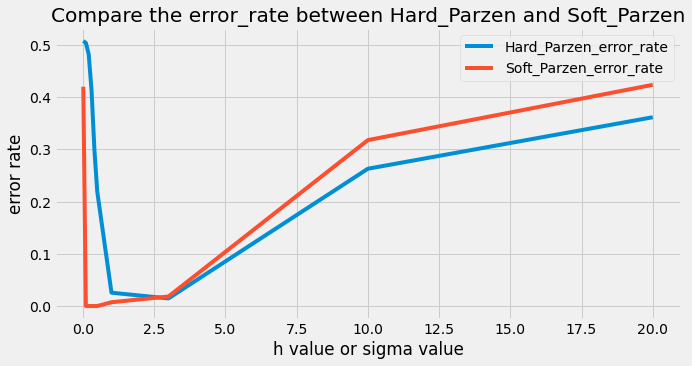

In [22]:
train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes = split_dataset(data)

arr_h      = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])
arr_sigma  = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])

# create a ErrorRate class and initialize it
error_rate = ErrorRate(train_data, valid_data, train_labels, valid_labels)

hp_error_rate = np.zeros_like(arr_h, dtype=float)
sp_error_rate = np.zeros_like(arr_sigma, dtype=float)

for i in range(len(arr_h)):
  hp_val_error_rate, hp_train_error_rate = error_rate.hard_parzen(arr_h[i])
  hp_error_rate[i] = hp_val_error_rate

for j in range(len(arr_sigma)):
  sp_val_error_rate, sp_train_error_rate = error_rate.soft_parzen(arr_sigma[j])
  sp_error_rate[j] = sp_val_error_rate

print(hp_error_rate)
print(sp_error_rate)

#draw a single plot with two lines
plt.plot(arr_h, hp_error_rate, label='Hard_Parzen_error_rate')
plt.plot(arr_h, sp_error_rate, label='Soft_Parzen_error_rate')
plt.xlabel("h value or sigma value")
plt.ylabel('error rate')
plt.title("Compare the error_rate between Hard_Parzen and Soft_Parzen")
plt.legend()
plt.show()

**Give a detailed discussion of your observations.**<br>
**Answer:** For hard parzen algorithm, when $h=2.5, 3.0$, it will obtain the lowest error rate. When $h<2.5$, the less h is, the more error rate is. When $h>3.0$, the bigger h is, the more error rate is. That is to say, distance parameter h is too small and too big, that cause error rate to increase.

For soft parzen algorithm, when $ \sigma=0.1, 0.2, 0.3, 0.4, 0.5$, error rate is near 0. When sigma=0.01, error rate is very big.Furthermore, when sigma>0.5, the bigger sigma is, the larger error rate is. That is to say, the proper sigma parameter $ \sigma \in [0.1, 0.2, 0.3, 0.4, 0.5]$     

6. [5 points]
**Question**. Implement a function **get_test_errors** that uses the
evaluated validation errors from the previous question to select $h^∗$ and
$σ^∗$ , then computes the error rates on the test set. The value $h^∗$ is the
one (among the proposed set in question 5) that results in the smallest
validation error for Parzen with hard window, and $σ^∗$ is the parameter
(among the proposed set in question 5) that results in the smallest
validation error for Parzen with RBF. <br>
The function should take as input the dataset and split it using question 4. The expected output is an array of size 2, the first value being the error rate on the test set of Hard Parzen with parameter $h^∗$
(trained on the training set), and the second value being the error rate
on the test set of Soft RBF Parzen with parameter $σ^∗$ (trained on the
training set).

In [23]:
def get_test_errors(banknote, star_h=3.0, star_sigma=0.3):
    pass    
    # function get_test_errors that uses the evaluated validation errors 
    # from the previous question to select  ℎ∗  and  σ∗, 
    # then computes the error rates on the test set. 
    # The value  ℎ∗  is the one (among the proposed set in question 5) 
    # that results in the smallest validation error for Parzen with hard window.
    # σ∗  is the parameter (among the proposed set in question 5) 
    # that results in the smallest validation error for Parzen with RBF.
        
    train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes = split_dataset(data) 
    # the value star_h is the one (among the proposed set in question 5) 
    # that results in the smallest validation error for Parzen with hard window
    x_hard_parzen      = HardParzen(star_h)
    x_hard_parzen.train(train_data, train_labels)
    y_hp_pred_test_lab = x_hard_parzen.compute_predictions(test_data)
    y_hp_conf_matrix   = confusion_matrix(test_labels, y_hp_pred_test_lab)
    y__hp_error_rate   = comput_test_error(y_hp_conf_matrix)

    star_sigma_sq = star_sigma**2
    # σ∗  is the parameter (among the proposed set in question 5) 
    # that results in the smallest validation error for Parzen with RBF.
    x_soft_RBFParzen     = SoftRBFParzen(star_sigma_sq)
    x_soft_RBFParzen.train(train_data, train_labels)
    y_soft_pred_test_lab = x_soft_RBFParzen.compute_predictions(test_data)
    y_soft_conf_matrix   = confusion_matrix(test_labels, y_soft_pred_test_lab)
    y_soft_error_rate    = comput_test_error(y_soft_conf_matrix)

    # expected output is an array of size 2, 
    # the first value being the error rate on the test set of Hard Parzen with parameter ℎ*
    # the second value being the error rate on the test set of Soft RBF Parzen with parameter σ∗
    list_error_rate = [y__hp_error_rate, y_soft_error_rate]
    hp_sp_error_rate = np.array(list_error_rate, dtype=float)

    return hp_sp_error_rate

In [26]:
get_test_errors(data, star_h=3.0, star_sigma=0.1)

array([0.00729927, 0.        ])

7. [5 points]
**Question**. Include in your report a discussion on the running time
complexity of these two methods. How does it vary for each method
when the hyperparameter h or σ changes? Why ?

In [32]:
import time
from datetime import timedelta

train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes = split_dataset(data)

repeat_error_rate = ErrorRate(train_data, valid_data, train_labels, valid_labels)
#print(repeat_error_rate.hard_parzen(arr_sigma[i]))

arr_h   = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])
hp_time = np.zeros_like(arr_h,dtype=float)
for i in range(len(arr_h)):
  hp_start_time = time.time()
  repeat_error_rate.hard_parzen(arr_h[i])
  hp_time[i]    = time.time() - hp_start_time  
  
arr_sigma = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])
sp_time = np.zeros_like(arr_sigma, dtype=float)
for j in range(len(arr_sigma)):
  sp_start_time = time.time()
  repeat_error_rate.soft_parzen(arr_sigma[j])
  sp_time[j]    = time.time() - sp_start_time

print("hp_time = ")
print(hp_time)
print("sp_time = ")
print(sp_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


hp_time = 
[0.18668962 0.18660641 0.18985415 0.17572403 0.17302465 0.17333174
 0.17466164 0.27933335 1.27485037 1.98644376]
sp_time = 
[2.7162919  2.70941401 2.73479557 2.67663622 2.68910503 2.67660809
 2.62141061 2.62936401 2.62370086 2.60773039]


**How does it vary for each method when the hyperparameter h or σ changes? Why ?**<br>
**Answer:** For **hard Parzen**, With the distance h increasing, time-cost increases. Because when h becomes large, the number of the involved points rises up. So the algorithm complexity shoot up.<br>
But for **soft Parzen**, the cost time of soft parzen doesn't change much, with the increasement of $\sigma$. Because every time, it computes all points, which doesn't change. So the algorithm complexity keeps nearly stable.

8. [5 points]
Question. <br> Implement a random projection (Gaussian sketch) map to
be used on the input data: <br>
Your function **project_data** should accept as input a feature matrix
X of dimension n × 4 , as well as a 4 × 2 matrix A encoding our
projection. <br>
Define $p : x \mapsto \frac{1}{\sqrt2}A^Tx$ and use this random projection map to reduce the dimension of the inputs (feature vectors of the dataset) from 4 to 2. <br> 
Your function should return the output of the map p when applied to
X, in the form of a $n \times 2$ matrix. <br>
e.g. $project\_data( X_{n,4}, A_{4,2}) = X_{n,2}^{proj}$ 

In [33]:
import numpy as np
import math

def random_projections(X, A):
    pass
    proj_X = np.dot(X, A)/math.sqrt(2)
    return proj_X

In [34]:
# the following is for testing function random_projections()
x = np.array([[1, 2, 3, 4], [5, 6, 7, 8],[9, 10, 11, 12]])
A = np.array([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6], [0.7, 0.8]])
proj = random_projections(x, A)

print(x)
print(type(x))
print(A)
print(proj)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
<class 'numpy.ndarray'>
[[0.1 0.2]
 [0.3 0.4]
 [0.5 0.6]
 [0.7 0.8]]
[[ 3.53553391  4.24264069]
 [ 8.06101731  9.89949494]
 [12.58650071 15.55634919]]


9. [10 points]
**Question**. Similar to Question 5, compute the validation errors of
Hard Parzen classifiers trained on 500 random projections of the training set, for<br>
<center>$h ∈ \{0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0\}$</center> <br>
The validation errors should be computed on the projected validation
set, using the same matrix A. To obtain random projections, you may
draw A as 8 independent variables drawn uniformly from a gaussian
distribution of mean 0 and variance 1. <br>
You can for example store these validation errors in a 500 × 9 matrix,
with a row for each random projection and a column for each value of
h.<br>
Do the same thing for RBF Parzen classifiers, for
<center>$σ ∈ {0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0}$</center><br>
Plot and include in your report in the same graph the average values
of the validation errors (over all random projections) for each value of
h and σ, along with error bars of length equal to 0.2× the standard
deviations. <br>
How do your results compare to the previous ones?

In [35]:
import random
import numpy

def create_mat_A(mu=0.0, sigma=1.0):
  list = [random.normalvariate(mu, sigma) for i in range(8)]
  mat_A = np.array(list).reshape((4, 2))
  return mat_A

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


mean_error_rate_every_h = 
[0.48983212 0.38908029 0.26436496 0.19394891 0.15684672 0.13865693
 0.13018978 0.18288321 0.34280292 0.4069854 ]
mean_error_rate_every_sigma = 
[0.2709781  0.11218978 0.10920438 0.10972993 0.11321898 0.11757664
 0.1399562  0.20151095 0.35027737 0.41785401]


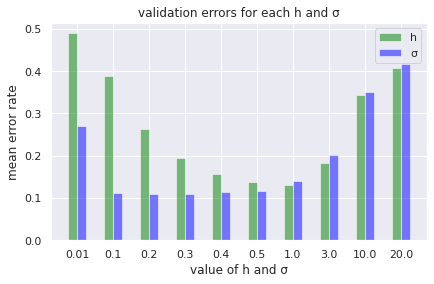

<Figure size 432x288 with 0 Axes>

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mu, sigma = 0.0, 1.0
train_data, train_labels, valid_data, valid_labels, test_data, test_labels, label_list, n_classes = split_dataset(data)

arr_h     = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])
arr_sigma = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])

#store these validation errors in a 500 × 10 matrix
pj_hp_valid_errors = np.zeros((500,10), dtype=float)
pj_sp_valid_errors = np.zeros((500,10), dtype=float)

for j in range(500):
  
  # Implement a random projection (Gaussian sketch) map to be used on the input data
  mat_A           = create_mat_A(0.0, 1.0)
  proj_train_data = random_projections(train_data, mat_A)
  proj_valid_data = random_projections(valid_data, mat_A)
  proj_test_data  = random_projections(test_data, mat_A)

  proj_error_rate = ErrorRate(proj_train_data, proj_valid_data,
                              train_labels, valid_labels)
  
  for k in range(len(arr_h)):
    pj_hp_val_error_rate, pj_hp_train_error_rate = proj_error_rate.hard_parzen(arr_h[k])
    pj_hp_valid_errors[j, k] = pj_hp_val_error_rate

  for m in range(len(arr_sigma)):
    pj_sp_val_error_rate, pj_sp_train_error_rate = proj_error_rate.soft_parzen(arr_sigma[m])
    pj_sp_valid_errors[j, m] = pj_sp_val_error_rate

mean_error_rate_every_h     = np.mean(pj_hp_valid_errors, axis=0)
mean_error_rate_every_sigma = np.mean(pj_sp_valid_errors, axis=0)
std_error_rate_every_h      = np.std(pj_hp_valid_errors, axis=0)
std_error_rate_every_sigam  = np.std(pj_sp_valid_errors, axis=0)
print("mean_error_rate_every_h = ")
print(mean_error_rate_every_h)
print("mean_error_rate_every_sigma = ")
print(mean_error_rate_every_sigma)

# --------------------- begin drawing plot-----------------------------
# Plot Plot and include in your report in the same graph the average values of the validation errors
# (over all random projections) for each value of h and σ, 
# along with error bars of length equal to 0.2× the standard deviations
#------------------------------------------------------------------------------

sns.set(color_codes=True)
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False

# parameter of bar
Y1_mean_h     = mean_error_rate_every_h
Y2_mean_sigma = mean_error_rate_every_sigma
X             = np.arange(len(arr_h))
# arr_h & arr_sigma 

bar_width = 0.25

tick_label = ['0.01', '0.1', '0.2', '0.3', '0.4', '0.5', '1.0', '3.0', '10.0', '20.0']
 
# draw the bar    
plt.bar(X, Y1_mean_h, bar_width, align="center", color="green", label="h", alpha=0.5)
plt.bar(X+bar_width, Y2_mean_sigma, bar_width, color="blue", align="center", \
        label="σ", alpha=0.5)

plt.xlabel("value of h and σ")
plt.ylabel("mean error rate")
plt.title('validation errors for each h and σ')

plt.xticks(X+bar_width/2, tick_label)
plt.legend()
plt.show()
plt.savefig('result.png',dpi = 400)

**How do your results compare to the previous ones?**<br>
(1) Comparing with the previous ones, the entire plot of this result is similar for hard parzen algorithm and soft parzen algorithm. <br>
(2) But the lowest points have a little change. For hard parzen algorith, $h= 0.5, 1.0$, their mean error rates obtain the lowest point. But in the previous, $h=1.0, 3.0$, their mean error rates is lowest.  
(3) For soft parzen algorith, this results is same as the previous ones. When $\sigma = 0.1, 0.2, 0.3, 0.4, 0.5$, their mean error rates is lowest.
(4) From this example, we find that the way of random projections of the data set, can keep the relative distance between the points, reduce the algorithm complexity. 